In [1]:
!pip install bayesian-optimization
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=8e7549b675bf99fba37de561523b25eaa542d31f27c72b7ef0622d1eb520ef98
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [2]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
import psutil
import GPUtil

from bayes_opt import BayesianOptimization

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

device

device(type='cuda')

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
X = np.load("/content/drive/MyDrive/Parkinson/X.npy")
y = np.load("/content/drive/MyDrive/Parkinson/y.npy")
y_multi_class = np.asarray(np.nan_to_num(np.load("/content/drive/MyDrive/Parkinson/y_multi_class.npy")), dtype='uint8')

X.shape, y.shape, y_multi_class.shape

((44021, 100, 19), (44021,), (44021,))

In [28]:
# categorize the data
y_cat = np.eye(np.unique(y).shape[0], dtype='uint8')[y]
y_multi_class_cat = np.eye(np.unique(y_multi_class).shape[0], dtype='uint8')[np.asarray(y_multi_class, dtype='uint8')]

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y_multi_class_cat, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (29494, 100, 19)
Shape of the validation set:  (7264, 100, 19)
Shape of the test set:  (7263, 100, 19)
Shape of the train set:  (29494, 4)
Shape of the validation set:  (7264, 4)
Shape of the test set:  (7263, 4)


In [30]:
X_train_tensors = Variable(torch.Tensor(X_train)).to(device)
X_val_tensors = Variable(torch.Tensor(X_val)).to(device)
X_test_tensors = Variable(torch.Tensor(X_test)).to(device)

y_train_tensors = Variable(torch.Tensor(y_train)).to(device)
y_test_tensors = Variable(torch.Tensor(y_test)).to(device)
y_val_tensors = Variable(torch.Tensor(y_val)).to(device)

X_train_tensors.shape, X_val_tensors.shape, X_test_tensors.shape, y_train_tensors.shape, y_val_tensors.shape, y_test_tensors.shape

(torch.Size([29494, 100, 19]),
 torch.Size([7264, 100, 19]),
 torch.Size([7263, 100, 19]),
 torch.Size([29494, 4]),
 torch.Size([7264, 4]),
 torch.Size([7263, 4]))

In [31]:
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensors, y_test_tensors)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [34]:
class CnnModel(nn.Module):
  def __init__(self, num_classes, in_channels, out_channels, hidden_size_fc, kernel_size):
      super(CnnModel, self).__init__()
      self.num_classes = num_classes
      self.kernel_size = kernel_size
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.hidden_size_fc = hidden_size_fc

      self.conv1d_1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                        kernel_size=kernel_size, stride=2)

      self.conv1d_2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels,
                        kernel_size=kernel_size, stride=2)

      self.maxpooling = nn.MaxPool1d(kernel_size=2, stride=2)

      self.fc_1 =  nn.Linear(320, hidden_size_fc)
      self.fc = nn.Linear(hidden_size_fc, num_classes)

      self.relu = nn.ReLU()
      self.elu = nn.ELU()

      self.dp = nn.Dropout(p=0.3)

      self.counter = 0
      self.min_validation_loss = float('inf')

  def forward(self,x):

      output = self.conv1d_1(x.permute(0, 2, 1))
      output = self.relu(output)
      output = self.maxpooling(output)


      output = self.conv1d_2(output)
      output = self.relu(output)
      output = self.maxpooling(output)

      output = self.dp(output)

      output = torch.flatten(output, start_dim=1)

      out = self.fc_1(output)
      out = self.relu(out)
      out = self.fc(out)

      return out

  def early_stop(self, validation_loss, min_delta, patience):
    if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.counter = 0
    elif validation_loss > (self.min_validation_loss + min_delta):
        self.counter += 1
        if self.counter >= patience:
            return True
    return False

In [ ]:
def cnn_training(p1, p2, p3, p4):
  cnn_model = CnnModel(4, 19, int(p1), int(p2), int(p3)).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(cnn_model.parameters(), lr=p4)


  history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

  best_acc = 0

  for epoch in range(100):
    batch_train_acc = []
    batch_train_loss = []
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      cnn_model.train()
      outputs = cnn_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)


    epoch_loss = np.average(batch_train_loss)
    history["loss"].append(epoch_loss)
    accuracy = np.average(batch_train_acc)
    history["accuracy"].append(accuracy)

    with torch.no_grad():
      batch_val_acc = []
      batch_val_loss = []
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        cnn_model.eval()
        val_outputs = cnn_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

      epoch_val_loss = np.average(batch_val_loss)
      history["val_loss"].append(epoch_val_loss)
      val_accuracy = np.average(batch_val_acc)
      history["val_accuracy"].append(val_accuracy)

    if best_acc < val_accuracy:
      best_acc = val_accuracy

    if cnn_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
      break

  return best_acc

In [22]:
def cma_es(objective_function, initial_solution, population_size=10, max_generations=10):

    """
    Algorithme CMA-ES pour l'optimisation continue

    Args:
        objective_function: Fonction objectif à minimiser
        initial_solution: Solution initiale
        population_size: Taille de la population
        max_generations: Nombre maximum de générations

    Returns:
        Meilleure solution trouvée
        Meilleure valeur de fitness
        Liste des meilleures valeurs de fitness à chaque génération
        Liste des solutions à chaque génération
    """

    # Définir la dimension du problème
    n = len(initial_solution)

    # Paramètres de l'algorithme CMA-ES
    sigma = 1.0  # Écart-type initial
    mu = population_size // 2  # Taille de la moitié de la population
    lambda_ = population_size  # Taille de la population

    # Listes pour stocker les résultats
    best_fitness_list = []
    current_solution = initial_solution
    current_sigma = sigma
    solution_list = []

    # Itérer sur les générations
    for generation in range(max_generations):

        # Générer une population de solutions candidates
        solutions = np.abs(np.random.multivariate_normal(current_solution, current_sigma**2 * np.identity(n), lambda_))

        # S'assurer que les solutions généré respectent les intervalles
        solutions[solutions[:, 0] < 256, 0] = 2 - solutions[solutions[:, 0] < 256, 0]

        solutions[solutions[:, 0] > 1024, 0] = solutions[solutions[:, 0] > 1024, 0] - (solutions[solutions[:, 0] > 1024, 0] / 1024).astype(int) * 1024

        solutions[solutions[:, 1] < 128, 1] = 2 * 128 - solutions[solutions[:, 1] < 128, 1]

        solutions[solutions[:, 1] > 1024, 1] = solutions[solutions[:, 1] > 1024, 1] - (solutions[solutions[:, 1] > 1024, 1] / 1024).astype(int) * 1024

        solutions[solutions[:, 2] < 0.1, 2] = 2 - solutions[solutions[:, 2] < 0.1, 2]

        solutions[solutions[:, 2] > 0.5, 2] = solutions[solutions[:, 2] > 0.5, 2] - (solutions[solutions[:, 2] > 0.5, 2] / 0.5).astype(int) * 0.5

        solutions[solutions[:, 3] < 0.0001, 3] = 2 * 0.0001 - solutions[solutions[:, 3] < 0.0001, 3]

        solutions[solutions[:, 3] > 0.01, 3] = solutions[solutions[:, 3] > 0.01, 3] - (solutions[solutions[:, 3] > 0.01, 3] / 0.01).astype(int) * 0.01


        # Évaluer la fitness de chaque solution
        fitness_values = np.array([objective_function(sol) for sol in solutions])

        # Trier les solutions par fitness
        sorted_indices = (-fitness_values).argsort()
        solutions = solutions[sorted_indices]

        # Mettre à jour la moyenne des meilleures solutions
        new_mean = np.mean(solutions[:mu], axis=0)
        current_solution = new_mean

        # Mettre à jour l'écart-type
        z = solutions[:mu] - current_solution
        current_sigma = np.sqrt(np.sum(z**2) / mu)

        # Afficher la meilleure solution à chaque génération
        best_fitness = fitness_values[sorted_indices[0]]

        # Stocker les résultats
        best_fitness_list.append(best_fitness)
        solution_list.append(current_solution[0])

    return current_solution, best_fitness

In [ ]:
best_solution, best_fitness = cma_es(objective_function=transformer_training, initial_solution=[3, 128, 1, 0.001], population_size=10, max_generations=10)
print(f'num_heads = {int(best_solution[0])}, hidden_dim {int(best_solution[1])}, num_layers {int(best_solution[2])}, learning_rate {best_solution[3]:.4f}')
print(f'target = {best_fitness}')

In [23]:
cnn_model = CnnModel(2, 19, 256, 1024, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

import time

history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

# Get GPU usage before running your code
if len(GPUtil.getGPUs()) != 0:
  start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

print("----------------------------------------------------------------------------------------------")

for epoch in range(100):
  batch_train_acc = []
  batch_train_loss = []
  with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      cnn_model.train()
      outputs = cnn_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)

      pbar.update(1)

  epoch_loss = np.average(batch_train_loss)
  history["loss"].append(epoch_loss)
  accuracy = np.average(batch_train_acc)
  history["accuracy"].append(accuracy)

  with torch.no_grad():
    batch_val_acc = []
    batch_val_loss = []
    with tqdm(total=len(val_dataloader), desc = 'Validation batch') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        cnn_model.eval()
        val_outputs = cnn_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

        pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

  print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, epoch_loss, accuracy, epoch_val_loss, val_accuracy))
  print("----------------------------------------------------------------------------------------------")

  if best_acc < val_accuracy:
    best_acc = val_accuracy
    torch.save(cnn_model.state_dict(), f"best_model.pth")
  if cnn_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
    break

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
if len(GPUtil.getGPUs()) != 0:
  end_gpu_usage = GPUtil.getGPUs()[0].load * 100

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.84955, Accuracy: 0.70334, Val Loss: 0.45755, Val Accuracy: 0.82461
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.48970, Accuracy: 0.76107, Val Loss: 0.42357, Val Accuracy: 0.82214
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.46336, Accuracy: 0.78383, Val Loss: 0.46656, Val Accuracy: 0.75124
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.42864, Accuracy: 0.81224, Val Loss: 0.39418, Val Accuracy: 0.81209
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.40408, Accuracy: 0.82302, Val Loss: 0.34595, Val Accuracy: 0.86289
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.37992, Accuracy: 0.83835, Val Loss: 0.33022, Val Accuracy: 0.87128
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.36884, Accuracy: 0.84047, Val Loss: 0.32426, Val Accuracy: 0.87872
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.34901, Accuracy: 0.85184, Val Loss: 0.31728, Val Accuracy: 0.87569
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.32642, Accuracy: 0.86611, Val Loss: 0.27445, Val Accuracy: 0.89579
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.31910, Accuracy: 0.87118, Val Loss: 0.29529, Val Accuracy: 0.90006
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.30179, Accuracy: 0.87880, Val Loss: 0.25815, Val Accuracy: 0.90377
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.27979, Accuracy: 0.88816, Val Loss: 0.24715, Val Accuracy: 0.91093
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.26990, Accuracy: 0.89166, Val Loss: 0.24328, Val Accuracy: 0.90831
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.25762, Accuracy: 0.89807, Val Loss: 0.22486, Val Accuracy: 0.92002
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.24637, Accuracy: 0.90376, Val Loss: 0.21938, Val Accuracy: 0.91699
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.23785, Accuracy: 0.90637, Val Loss: 0.20408, Val Accuracy: 0.92428
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.22571, Accuracy: 0.91252, Val Loss: 0.21687, Val Accuracy: 0.92208
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.22548, Accuracy: 0.91281, Val Loss: 0.21445, Val Accuracy: 0.91878
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.21753, Accuracy: 0.91630, Val Loss: 0.21224, Val Accuracy: 0.92346
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.21140, Accuracy: 0.91866, Val Loss: 0.23264, Val Accuracy: 0.91685
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.20689, Accuracy: 0.92096, Val Loss: 0.17899, Val Accuracy: 0.93819
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.20420, Accuracy: 0.92388, Val Loss: 0.17964, Val Accuracy: 0.93585
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.20747, Accuracy: 0.92220, Val Loss: 0.20785, Val Accuracy: 0.92566
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.20378, Accuracy: 0.92371, Val Loss: 0.17988, Val Accuracy: 0.93722
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.19275, Accuracy: 0.92852, Val Loss: 0.19472, Val Accuracy: 0.93075
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.18431, Accuracy: 0.93081, Val Loss: 0.18231, Val Accuracy: 0.93709
----------------------------------------------------------------------------------------------


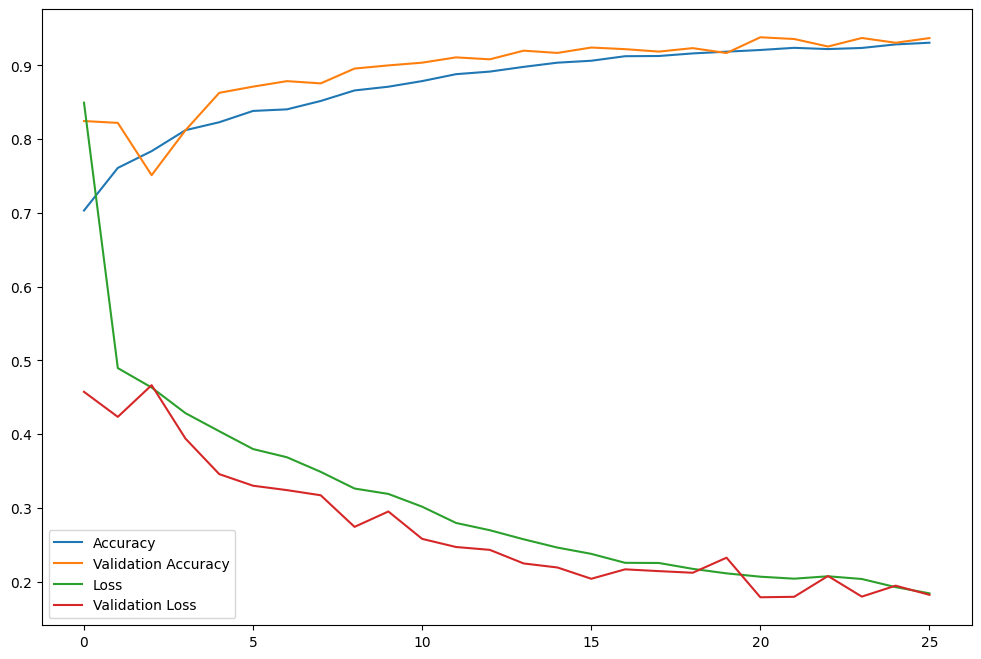

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

In [25]:
cnn_model.load_state_dict(torch.load("/content/best_model.pth"))

y_pred = []
y_real = []
with torch.no_grad():
    batch_test_acc = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
        cnn_model.eval()
        test_outputs = cnn_model(x_batch)

        _, test_predicted = torch.max(test_outputs, 1)
        y_real.extend(torch.max(y_batch, 1)[1].cpu().data.numpy())
        y_pred.extend(test_predicted.cpu().data.numpy())
        test_correct = torch.eq(torch.max(y_batch, 1)[1], test_predicted).sum().item()
        test_total = y_batch.size(0)
        batch_test_acc.append(test_correct / test_total)
        pbar.update(1)

test_accuracy = np.average(batch_test_acc)

precision = precision_score(y_real, y_pred, average='weighted')
recall = recall_score(y_real, y_pred, average='weighted')
f1 = f1_score(y_real, y_pred, average='weighted')

cm = confusion_matrix(y_real, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

macro_roc_auc_ovo = roc_auc_score(y_real, y_pred, multi_class="ovo", average="macro")

print(f'Loss: {history["val_loss"][-1]:.4f}')
print(f'Accuracy: {np.mean(test_accuracy):.4f}')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
if len(GPUtil.getGPUs()) != 0: print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Testing:   0%|          | 0/227 [00:00<?, ?it/s]

Loss: 0.1823
Accuracy: 0.9361
Precision: 0.9358775362782554
Recall: 0.936114553214925
F1 Score: 0.9359721551043988
TP: 6799
TN: 6799
FP: 464
FN: 464
AUC: 0.9220903014361652
CPU Usage: 50.699999999999996%
Memory Usage: 0.0%
GPU Usage: 21.0%
Execution Time: 94.71776103973389 seconds


Text(0.5, 1.0, 'Confusion Matrix')

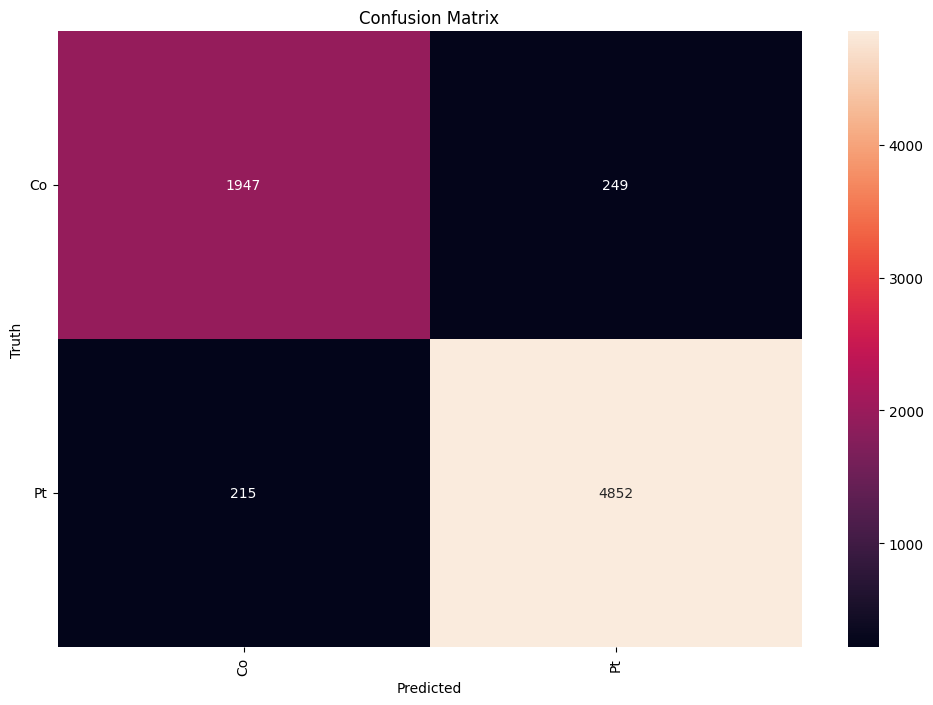

In [26]:
cm = confusion_matrix(y_real, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(2)+0.5, ['Co', 'Pt'], rotation=90)
plt.yticks(np.arange(2)+0.5, ['Co', 'Pt'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

In [35]:
cnn_model = CnnModel(num_classes=4, in_channels=19, out_channels=64, hidden_size_fc=100, kernel_size=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)


history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

# Get GPU usage before running your code
if len(GPUtil.getGPUs()) != 0:
  start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

print("----------------------------------------------------------------------------------------------")

for epoch in range(num_epochs):
  batch_train_acc = []
  batch_train_loss = []
  with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      cnn_model.train()
      outputs = cnn_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)

      pbar.update(1)

  epoch_loss = np.average(batch_train_loss)
  history["loss"].append(epoch_loss)
  accuracy = np.average(batch_train_acc)
  history["accuracy"].append(accuracy)

  with torch.no_grad():
    batch_val_acc = []
    batch_val_loss = []
    with tqdm(total=len(val_dataloader), desc = 'Validation batch') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        cnn_model.eval()
        val_outputs = cnn_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

        pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

  print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, epoch_loss, accuracy, epoch_val_loss, val_accuracy))
  print("----------------------------------------------------------------------------------------------")

  if best_acc < val_accuracy:
    best_acc = val_accuracy
    torch.save(cnn_model.state_dict(), f"best_model.pth")
  if cnn_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
    break

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
if len(GPUtil.getGPUs()) != 0:
  end_gpu_usage = GPUtil.getGPUs()[0].load * 100

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.20791, Accuracy: 0.47018, Val Loss: 0.97311, Val Accuracy: 0.56828
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.88994, Accuracy: 0.60747, Val Loss: 0.73226, Val Accuracy: 0.69232
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.73917, Accuracy: 0.69143, Val Loss: 0.64659, Val Accuracy: 0.72839
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.62102, Accuracy: 0.74455, Val Loss: 0.48649, Val Accuracy: 0.80713
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.54062, Accuracy: 0.78567, Val Loss: 0.41019, Val Accuracy: 0.84086
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.47118, Accuracy: 0.81527, Val Loss: 0.34296, Val Accuracy: 0.87183
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.42161, Accuracy: 0.83573, Val Loss: 0.32970, Val Accuracy: 0.88161
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.39714, Accuracy: 0.84877, Val Loss: 0.29989, Val Accuracy: 0.89221
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.36646, Accuracy: 0.86237, Val Loss: 0.26951, Val Accuracy: 0.90033
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.33904, Accuracy: 0.87268, Val Loss: 0.28350, Val Accuracy: 0.89854
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.32953, Accuracy: 0.87684, Val Loss: 0.30172, Val Accuracy: 0.88863
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.31099, Accuracy: 0.88332, Val Loss: 0.25287, Val Accuracy: 0.91066
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.29964, Accuracy: 0.88926, Val Loss: 0.23474, Val Accuracy: 0.91836
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.28389, Accuracy: 0.89426, Val Loss: 0.21880, Val Accuracy: 0.92057
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.28444, Accuracy: 0.89422, Val Loss: 0.24034, Val Accuracy: 0.91437
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.27052, Accuracy: 0.90154, Val Loss: 0.22412, Val Accuracy: 0.92057
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.26735, Accuracy: 0.90018, Val Loss: 0.22770, Val Accuracy: 0.92249
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.25542, Accuracy: 0.90820, Val Loss: 0.20489, Val Accuracy: 0.92800
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.24621, Accuracy: 0.90823, Val Loss: 0.20985, Val Accuracy: 0.92938
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.23795, Accuracy: 0.91318, Val Loss: 0.21390, Val Accuracy: 0.92181
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.23311, Accuracy: 0.91495, Val Loss: 0.18751, Val Accuracy: 0.93392
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.22960, Accuracy: 0.91659, Val Loss: 0.18131, Val Accuracy: 0.93461
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.22257, Accuracy: 0.91632, Val Loss: 0.18072, Val Accuracy: 0.93599
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.21664, Accuracy: 0.92102, Val Loss: 0.19814, Val Accuracy: 0.92855
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.21717, Accuracy: 0.92006, Val Loss: 0.18427, Val Accuracy: 0.93654
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.20762, Accuracy: 0.92437, Val Loss: 0.16389, Val Accuracy: 0.94218
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.21013, Accuracy: 0.92408, Val Loss: 0.16261, Val Accuracy: 0.94425
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.20212, Accuracy: 0.92591, Val Loss: 0.18029, Val Accuracy: 0.93805
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.20365, Accuracy: 0.92549, Val Loss: 0.18328, Val Accuracy: 0.93681
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.20101, Accuracy: 0.92834, Val Loss: 0.18801, Val Accuracy: 0.93268
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.19787, Accuracy: 0.92932, Val Loss: 0.18310, Val Accuracy: 0.93172
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.19407, Accuracy: 0.92917, Val Loss: 0.16474, Val Accuracy: 0.94053
----------------------------------------------------------------------------------------------


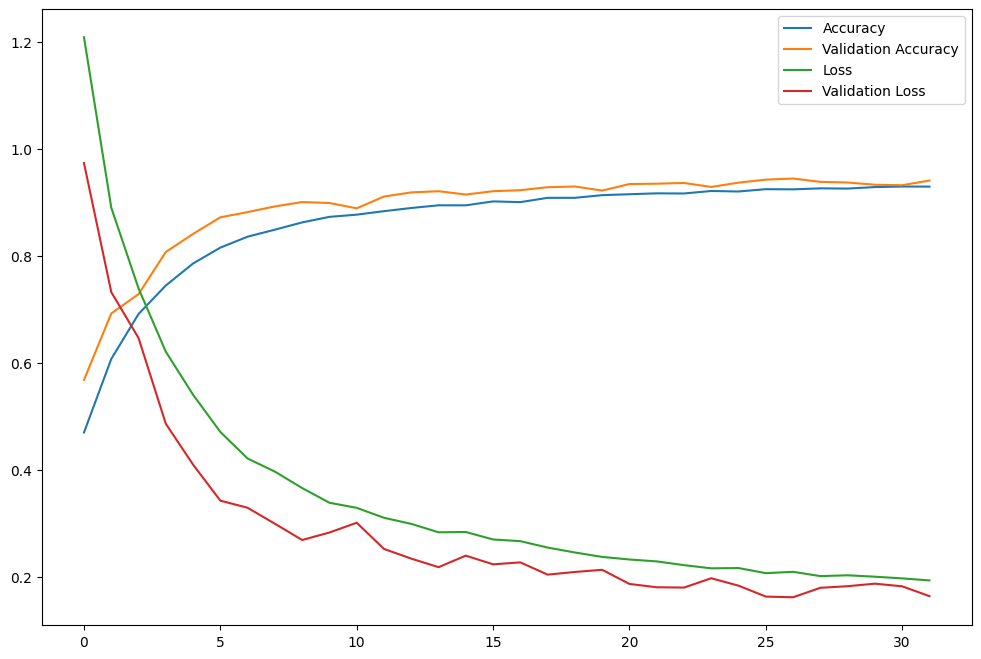

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

In [37]:
cnn_model.load_state_dict(torch.load("/content/best_model.pth"))

# Define the function to calculate accuracy
def calculate_accuracy(predictions, targets):
    _, predicted = torch.max(predictions, 1)
    correct = torch.eq(predicted, targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

all_pred = []
all_labels = []

cnn_model.eval()  # Set the model to evaluation mode
m = nn.Softmax(dim=1)
with torch.no_grad():
    test_accuracy = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for data in test_dataloader:
          inputs, labels = data
          outputs = cnn_model(inputs)
          all_pred.extend(np.asarray(m(outputs.cpu().data)))
          all_labels.extend(torch.max(labels, 1)[1])
          test_accuracy.append(calculate_accuracy(outputs, torch.max(labels, 1)[1]))
          pbar.update(1)

all_labels = np.asarray([int(x) for x in all_labels])
predicted = np.argmax(all_pred, axis=1)

precision = precision_score(all_labels, predicted, average='weighted')
recall = recall_score(all_labels, predicted, average='weighted')
f1 = f1_score(all_labels, predicted, average='weighted')

cm = confusion_matrix(all_labels, predicted)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

macro_roc_auc_ovo = roc_auc_score(all_labels, all_pred, multi_class="ovo", average="macro")

print(f'Loss: {history["val_loss"][-1]:.4f}')
print(f'Accuracy: {np.mean(test_accuracy):.4f}')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
if len(GPUtil.getGPUs()) != 0: print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Testing:   0%|          | 0/227 [00:00<?, ?it/s]

Loss: 0.1647
Accuracy: 0.9485
Precision: 0.9492394871254255
Recall: 0.9485061269447886
F1 Score: 0.9486084161291943
TP: 6889
TN: 21415
FP: 374
FN: 374
AUC: 0.9953131715975214
CPU Usage: 47.0%
Memory Usage: 0.0%
GPU Usage: 18.0%
Execution Time: 100.65695285797119 seconds


Text(0.5, 1.0, 'Confusion Matrix')

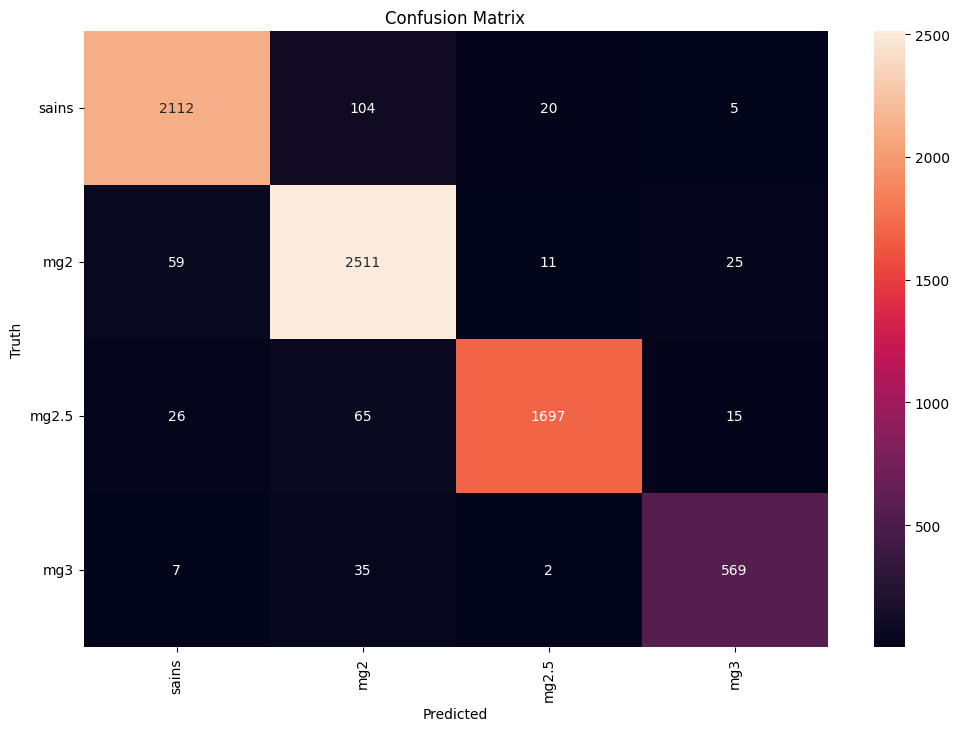

In [38]:
cm = confusion_matrix(all_labels, predicted)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(4)+0.5, ['sains', 'mg2', 'mg2.5', 'mg3'], rotation=90)
plt.yticks(np.arange(4)+0.5, ['sains', 'mg2', 'mg2.5', 'mg3'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

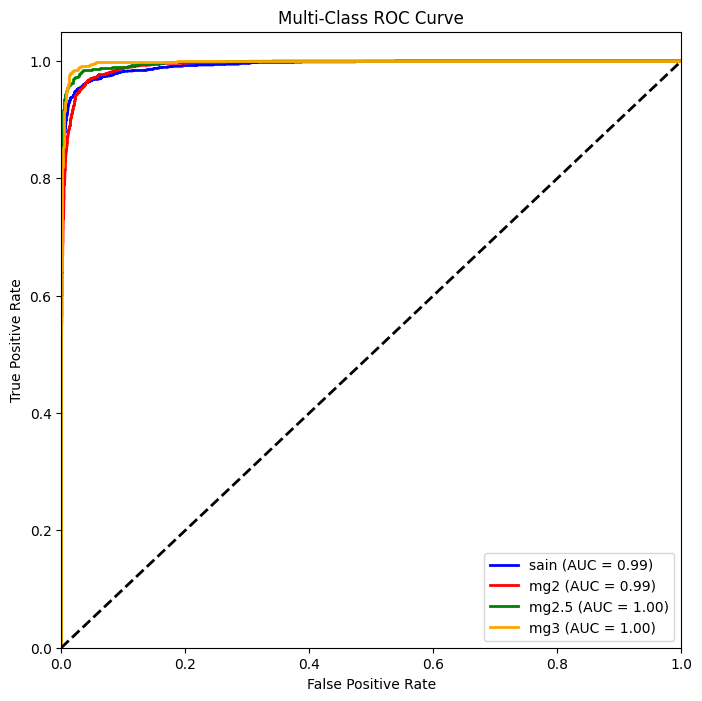

In [39]:
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_bin = label_binarize(all_labels, classes=np.unique(y_multi_class))

# Compute the predicted probabilities for each class
y_prob = np.asarray(all_pred)

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_multi_class))):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
classes = ['sain', 'mg2', 'mg2.5', 'mg3']
for i in range(len(np.unique(y_multi_class))):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='{0} (AUC = {1:.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()